# Introduction

Given an arbitrary graph $G$, the chromatic number of $G$ can be defined in many equivalent ways.  Most intuitively, perhaps, it may be defined as the minimum number of colors required such that each vertex of $G$ may be colored a different color than each of its neighbors, which is known as a proper coloring.  Another quite useful definition is that it is the minimum number of elements in a partition of the vertices of $G$ such that no two neighboring vertices are in the same partition.  (Each element in the partition is known as a color class, and in the proper coloring of $G$ associated to that partition, are all colored with the same coloring.)

The problem of finding, for an arbitrary graph $G$, the least $k$ such that $G$ admits a proper $k$-coloring is known as the problem of graph coloring, and it is an NP-hard problem.  In fact, it is NP-complete in general to merely check whether $G$ admits a proper $k$-coloring, for any specified $k$ which is at least 3 (though obviously in specific cases, such as where $k$ is more than the number of vertices of $G$, this may be easier).  The computational complexity of performing this check escalates rapidly as $k$ increases, approximately exponentially in $\frac{k}{2}$, so attention is generally restricted to $k = 3$.

In previous work at Wesleyan University, I demonstrated that given a proper $k$-coloring of $G$ and an arbitrary, specified root vertex, it was possible to construct a spanning tree $T$ of $G$ so that a simple flooding algorithm, applied relative to the root vertex, produced a valid coloring of $G$.  The flooding algorithm itself was straightforward to define, taking the traditional definition that "colors" are actually numbers from 0 to $k-1$: color the root vertex by the first color, then color all vertices exactly $n$ steps away from the root vertex by the color $n \pmod{k}$.  This is an extremely easy algorithm to implement for a computer, requiring approximately linear time in the number of vertices of $G$ in the worst case, and thus the problem of graph coloring is equivalent to a search problem on the set of all spanning trees of $G$.  Notably, there is significant reason to expect there to be multiple valid trees for a given root node, as each possible ordering of colors ought to correspond to at least one valid tree, and the only circumstance where all those trees could conceivably be required to be the same (which is to say only one proper coloring of $G$ exists) in fact permits the construction of a unique tree for each ordering.  Thus this forms a search problem on a space with at most $n^{n-2}$ elements where numerous elements will be accepted, if any are accepted at all.

In this project, I consider the chromatic number $k = 3$ to be the target for my analysis, and I analyze three well-known graphs: the Petersen Graph, the edge graph of the regular octahedron, and the Gr&ouml;tzsch Graph, each having exactly or approximately this chromatic number.  I generate the set of spanning trees for each of these graphs, and quantify how close each spanning tree is to a flooding spanning tree in two different ways, for each spanning tree in the set.  Then, with the data set thus constructed, I compare how well those two measures align with each another on the same graph and with themselves across graphs, to understand better how one measure (which is significantly easier to minimize) can be used to approximate the other (which is required to be minimized to find the chromatic number).

In [9]:
%matplotlib widget
import spanningTreeModule as tree
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'The three graphs under consideration')

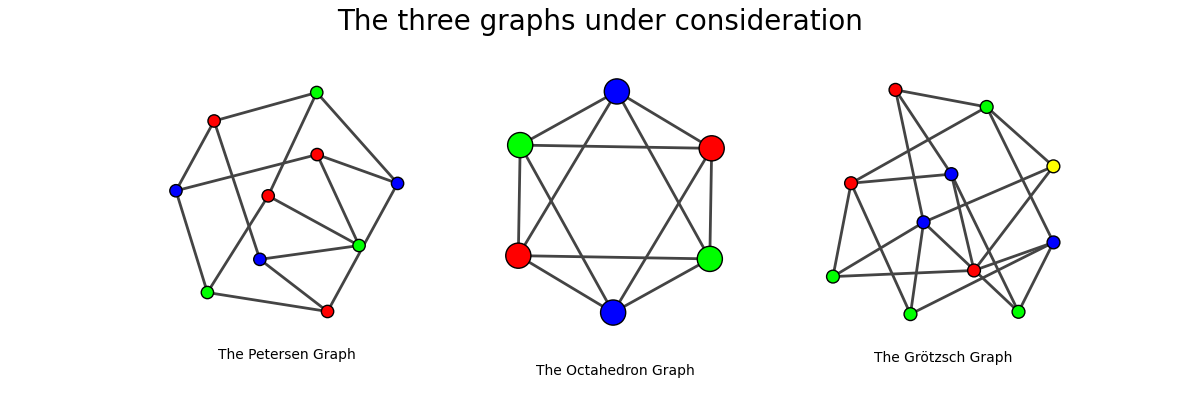

In [10]:

firstGraph = ig.Graph.Famous('Petersen')
secondGraph = ig.Graph.Famous('Octahedron')
thirdGraph = ig.Graph.Famous('Grotzsch')

fig, axes = plt.subplots(1,3, figsize = (4 * 3, 4))
ig.plot(firstGraph, target=axes[0], vertex_color = ['red', 'blue', 'red', 'green', 'blue', 'green','green', 'blue', 'red', 'red'])
ig.plot(secondGraph, target=axes[1], vertex_color = ['red', 'blue', 'green', 'green', 'red', 'blue'])
ig.plot(thirdGraph, target=axes[2], vertex_color = ['red', 'blue', 'blue', 'green', 'red', 'blue', 'green', 'green', 'red', 'green', 'yellow'])
axes[0].set_xlabel('The Petersen Graph')
axes[1].set_xlabel('The Octahedron Graph')
axes[2].set_xlabel('The Grötzsch Graph')
fig.suptitle('The three graphs under consideration', fontsize='20')

# Motivation

The problem of graph coloring and of finding the chromatic number is relevant in several fields beyond pure mathematics.  It is of course an NP-complete problem, and hence an improved method of solution would enable far faster solution to any other NP-complete problem, including those with direct utility such as the traveling salesman problem or the knapsack problem.  Further, there are direct applications of finding a graph's chromatic number to solving scheduling problems, so that finding the chromatic number of an appropriate graph is equivalent to finding the minimum number of timeslots to perform some collection of tasks, some of which may interfere with others being done concurrently.  Thus better approximations or algorithms for finding the chromatic number can help optimize such problems, which are most relevant in the functioning of computer systems.  Similarly, finding the chromatic number is equivalent to finding the minimum number of memory addresses required to store a collection of variables, which helps in the optimization of compiling programs and ensuring they run as quickly as possible and with as little memory usage as possible.

That all being said, such concerns are not why I am investigating the problem (though they are very good motivations).  The reason for that is much simpler - the problem of finding the chromatic number of an arbitrary graph has been an open question explicitly asked for nearly 150 years, and it remains as possibly the oldest problem which falls under the umbrella of NP-complete, being one of the original 21 problems demonstrated by Karp to be such and being by far the oldest problem of those.  It is a very famous problem in graph theory, and even its many variations attract significant attention.  Of course, I do not expect to be able to solve this problem outright, but the current methods of solution of the problem are primarily very cleverly-designed guess-and-check algorithms, and my objective is to highlight a different path by which useful results might be obtained. 

# Contribution

Nearly uniformly, the problems of finding whether a graph may be colored with $k$ colors and producing a valid coloring of that graph with $k$ colors are conflated with each other.  This is primarily because the most frequently-applied methods of finding whether a graph may be colored with $k$ colors involve attempting to do so, and either successfully coloring the graph or demonstrating that the graph cannot be so colored.  That is to say, a solution to the second problem is implicitly a solution to the first, and thus many solutions to the first problem are solutions to the second, as well.  But there is an obvious issue with this: given that it is possible to color a graph with $k$ colors, it is still very difficult to produce a coloring of that graph with $k$ colors in anything approaching a reasonable time.  (Formally speaking, the problem of coloring the graph is a co-NP-complete problem; thus a solution to an NP-complete problem does not, in general, provide a solution to it.)

This motivated the methodology used: by proving the existence of a specific spanning tree which is guaranteed to produce a proper coloring in polynomial time, we may simply check whether a given spanning tree produces a proper coloring, and attempt to modify that tree in a way to make it more likely to produce a proper coloring.  With perfect knowledge of the entire spanning set, it is possible to perform the necessary modifications in polynomial time, as there are only polynomially many edges which could differ between two spanning trees of the same graph.  Thus, to better understand the behavior and heuristics involved in any effective algorithm to find a truly optimal spanning tree, the most effective strategy is simply to generate and analyze the complete set of spanning trees of a graph; this is only practical in a reasonable time-frame for small graphs, but considering that even such small graphs will have many spanning trees and most of these will not generate a proper $k$-coloring of the graph, even small graphs may shed significant light on key behaviors of such an algorithm.

# Methods

I begin with three graphs: the Petersen Graph and Octahedron graph, which have chromatic number 3, and the Gr&ouml;tzsch Graph, which has chromatic number 4, as instantiated at the beginning.  Using the fact that each of these graphs is fairly sparse, which is to say that they have relatively few edges for their number of vertices, I generate the complete set of their spanning trees (as a list of tuples) by simply iterating through every possible list of tuples of the appropriate length, and selecting only those which form a spanning tree.  This is of course highly inefficient when the number of spanning trees is very small relative to the total size of that set (as it is for sparse graphs), but for this purpose it is reasonably fast regardless as there are not many trees to select from in the first place.  As it would be significant overkill to implement a complicated algorithm which only generates spanning trees instead of a very simple one which selects the spanning trees from a larger set, the tradeoff of a few seconds' extra computation time for the simpler algorithm is worthwhile.

For each spanning tree I also create the python-igraph Graph object which is described by the edge set of that tree.  I then store each tuple and graph in a dictionary, keyed by a numerical index so that I may refer to each spanning tree by a single number, as I will need both representations later on.

In [11]:
firstSpanningTreeDict = tree.generateSpanningTreeDict(firstGraph)
secondSpanningTreeDict = tree.generateSpanningTreeDict(secondGraph)
thirdSpanningTreeDict = tree.generateSpanningTreeDict(thirdGraph)

With these in hand, I transform the data set to a more useful form: for each tree I apply the flooding algorithm, and find how many edges connect vertices of the same color in the original graph when that particular tree is flooded.  This value is stored in the error dictionaries - keyed to the same index in these dictionaries as the corresponding spanning tree was keyed to in its own dictionary previously.

Further, I construct what I call the "greedy graph" of the set of spanning trees.  This uses the fact that a graph is, strictly speaking, just a collection of relationships - it is a graph where each vertex is the key of a spanning tree (to stand in for the spanning tree itself), and there is a *directed* edge pointing from tree 1 to tree 2 if tree 1 is "adjacent" to tree 2 in the set of spanning trees (in other words, if their edge set differs by exactly one edge) *and* if tree 2's value in the error dictionary is smaller than that of tree 1.  Thus the trees with local minima, relative to their values in the error dictionary and their neighbors in the set of spanning trees, are sinks of the resulting graph, and the trees with local maxima are sources.  As the entries in the error dictionary are non-negative integers, both of these are guaranteed to exist.

In essence, this represents all possible paths of the algorithm which simply checks "can I improve the coloring I have by changing one edge?"  Obviously, this is not always possible to do, and there are indeed local minima which are not global minima for all but the very simplest of graphs, as otherwise the problem of graph coloring would not be NP-complete.  This is however the very simplest algorithm to color a graph, at least in terms of those which can be sensibly represented as a walk of some form on the set of spanning trees of the graph.  It is not guaranteed to converge to a tree which yields the appropriate coloring, but because of the requirement that the coloring is able to be improved at every step, it is guaranteed to terminate in at most as many steps as the number of edges of the graph (which is obviously an upper bound on the values in the error dictionary), which is to say polynomially quickly.

In [12]:
firstGreedyGraph, firstErrorDict = tree.treeSetToMetaGraph(firstSpanningTreeDict, chromaticNumber=3, graph=firstGraph)
secondGreedyGraph, secondErrorDict = tree.treeSetToMetaGraph(secondSpanningTreeDict, chromaticNumber=3, graph=secondGraph)
thirdGreedyGraph, thirdErrorDict = tree.treeSetToMetaGraph(thirdSpanningTreeDict, chromaticNumber=3, graph=thirdGraph)

I then plot, for each of the three graphs with which I work, the results obtained when the flooding algorithm is applied with the chromatic number set equal to 3.  Specifically, for the greedy graphs, I plot a histogram of the furthest distance I can travel from each point without violating the orientation of the edges, which represents an upper bound on the number of times that the function would iterate before termination when beginning at that point.  Meanwhile, for the error dictionaries I simply plot the histogram of the error for each spanning tree over all spanning trees.

For a graph where the chromatic number is 3, like the Petersen Graph and the octahedron Graph, the greedy graph histogram will report all local and global minima in the bin for 0, and every other point is an intermediary step.  Conversely the error dictionary histogram reports only the global minima in the bin for 0; thus we can estimate the likelihood that the algorithm converges to a global minimum as opposed to a local minimum as the ratio between the number of global minima (from the error histogram) to the number of overall minima (from the other histogram).  This isn't a perfect comparison, as it's not necessarily equally likely to land at each minimum given the simplicity of the algorithm, but further analysis would likely be too in-depth to cover in much short of a graduate thesis.

For a graph where the chromatic number is larger than 3, however, such as the Gr&ouml;tzsch Graph, the greedy graph histogram will continue to report all local and global minima in the bin for 0, but the global minimum is no longer 0 as a graph with chromatic number strictly larger than 3 cannot be 3-colored by definition.  For this reason, the histogram will have a least bin with some other value - what that value is, however, will depend on the graph chosen.  

In both cases, however, the histograms should approximate each other (albeit possibly with translation) - after all, the algorithm is intended to color a graph with a minimal number of colors, and the error dictionary makes precise how much more work is needed at a given step to make that happen.  In general we can predict that the greedy graph is likely to be slightly more skewed towards zero, as an improvement from one spanning tree to an adjacent one is not necessarily improvement by only one fewer edge being problematic, but further and more sweeping generalizations are likely outside the scope of this project.

The histograms below are rendered with transparency to make it clearer what the values are where they overlap.

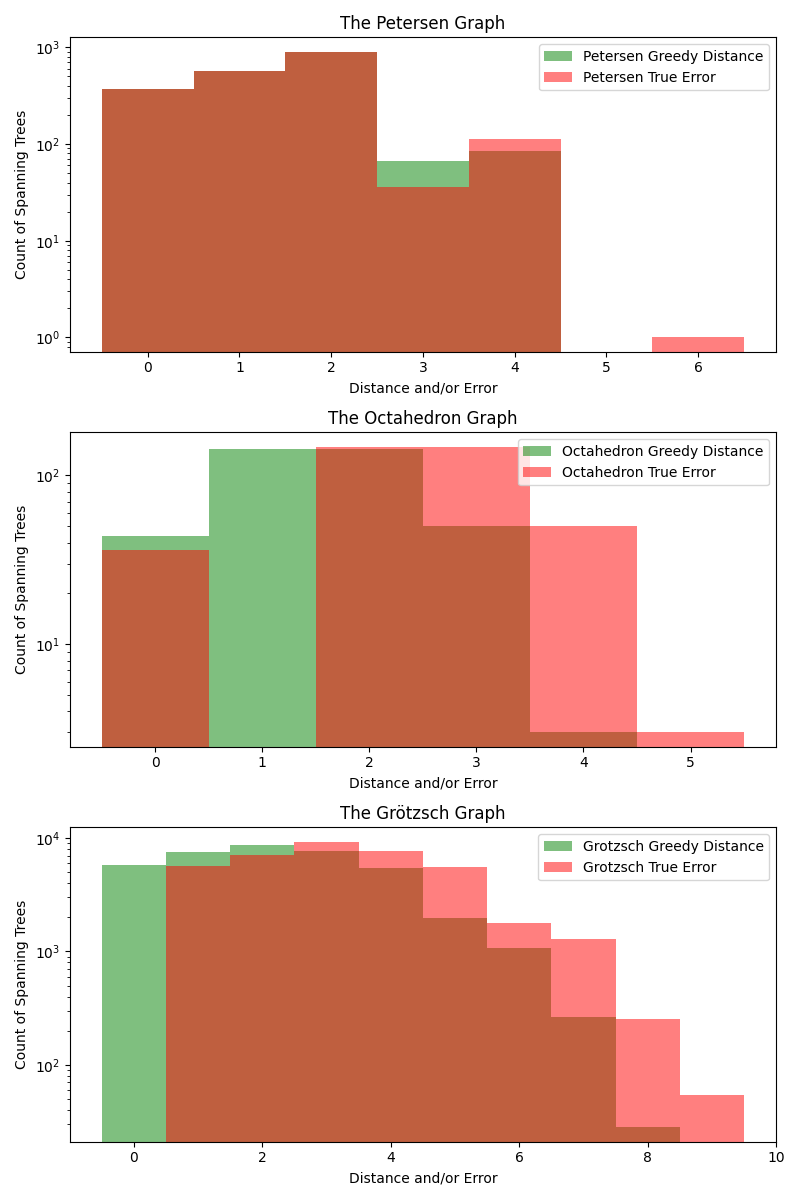

In [15]:
n_plots = 3

fig, axes = plt.subplots(n_plots, 1, figsize=(8, 4 * n_plots), tight_layout=True)

greedy0 = axes[0].hist(firstGreedyGraph.vs.eccentricity(), bins=np.arange(-0.5, max(firstGreedyGraph.vs.eccentricity()) + 1.5, 1), color = 'green', alpha = 0.5, label = 'Petersen Greedy Distance', log=True)
greedy1 = axes[1].hist(secondGreedyGraph.vs.eccentricity(), bins=np.arange(-0.5, max(secondGreedyGraph.vs.eccentricity()) + 1.5, 1), color = 'green', alpha = 0.5, label = 'Octahedron Greedy Distance', log=True)
greedy2 = axes[2].hist(thirdGreedyGraph.vs.eccentricity(), bins=np.arange(-0.5, max(thirdGreedyGraph.vs.eccentricity()) + 1.5, 1), color = 'green', alpha = 0.5, label = 'Grotzsch Greedy Distance', log=True)
error0 = axes[0].hist(firstErrorDict.values(), bins=np.arange(-0.5, max(firstErrorDict.values())+1.5, 1), color = 'red', alpha = 0.5, label = 'Petersen True Error', log=True)
error1 = axes[1].hist(secondErrorDict.values(), bins=np.arange(-0.5, max(secondErrorDict.values())+1.5, 1), color = 'red',  alpha = 0.5, label = 'Octahedron True Error', log=True)
error2 = axes[2].hist(thirdErrorDict.values(), bins=np.arange(-0.5, max(thirdErrorDict.values())+1.5, 1), color = 'red',  alpha = 0.5, label = 'Grotzsch True Error', log=True)

for ax in axes:
    ax.set_xlabel('Distance and/or Error')
    ax.set_ylabel('Count of Spanning Trees')
    ax.legend(loc='upper right')
axes[0].set_title('The Petersen Graph')
axes[1].set_title('The Octahedron Graph')
axes[2].set_title('The Grötzsch Graph')


plt.show()

# Main Results

It is clear that in all three cases (with some caveats) the histograms approximate each other closely, which means that this is, rather remarkably, generally an effective algorithm to color graphs.  The distance fairly closely approximates the error, which means that for most spanning trees in each of the three graphs that do not already color the graph optimally, there is a successor spanning tree which colors the graph only slightly better, and which eventually leads towards a global minimum with enough applications of the algorithm.  This suggests that local minima are not generally speaking strong attractors of the algorithm's output, as most points have trajectories which lead away from local minima and therefore random selection would suggest that most trajectories also should lead away from local minima.  Of course, there are also a lot of local minima, so those effects would seem on the whole to be plausible to balance out such that the odds of finding a true global minimum aren't great.  For the three graphs under consideration, at least, it seems that the global minima are reasonably stable and likely to be found by a simple algorithm.

The histograms are of course all rendered on logarithmic scale, as otherwise their own scales are vastly different and they would be nearly incomparable.  The Gr&ouml;tzsch Graph has by far the most spanning trees, being a couple tens of thousands; the Petersen graph is known to have precisely 2000 spanning trees; and the octahedron graph has merely a few hundred at most.  However interesting features of each histogram further point to unique features of each graph, which are not obvious from a cursory scan of each graph's spanning trees.

The Petersen Graph has a "least optimal" spanning tree, which is unique and which causes significantly more vertices to have neighbors of the same color than any other spanning tree - all adjacent spanning trees are at least 2 better in terms of their raw error, and it's possible that they're better as that's merely an upper bound.  Further, it has more trees with an error of 4 than an error of 3, which is likely due to some peculiarity in its symmetry or its nature as a snark graph.

The Octahedron Graph is relatively ordinary-appearing, except that it seems that no spanning tree is capable of generating a coloring with only one pair of mismatched vertices - every tree either generates a proper $k$-coloring or misses the mark by two or more pairs of vertices.  This interesting effect can also be seen in how the histogram of the errors appears very similar to what would be obtained from splitting the histogram of the distances slightly - the last two pairs of vertices seem to be the only time when the algorithm consistently skips ahead by two steps (or else halts, unable to improve).

The Gr&ouml;tzsch Graph is, interestingly enough, very similar in behavior to the other two graphs, except that the error minimizes at 1 and thus the distance to the furthest point is approximately the same as the error + 1.  That is to say, despite the fact that the error is always positive, it seems that most trajectories still terminate at a global minimum, and thus generate an optimal mapping.  Likewise, it seems that most trajectories would, on average, improve the coloring by only one edge conflict at each step, regardless of whether the chromatic number being worked with was in fact able to yield a proper coloring of the graph or not - thus this would seem to be an effective algorithm to even merely approximately $k$-color a graph.

# Conclusion

Other, cleverer algorithms are conceivable to work with, which would use heuristic arguments to locally increase the error of the coloring on the next tree selected, but set the trajectory that the tree evolves towards towards a better ending state, being less likely to be stuck in a particularly poor local minimum and indeed possibly being able to escape some local minima.  These algorithms would result in different orientations being applied to the adjacency graph of the set of spanning trees (and perhaps more edges being added).  However, such algorithms would likely lose the chief benefit of the previously-noted, which is guaranteed convergence in polynomial time, because any algorithm which was guaranteed to converge in polynomial time to the global minimum using only the current state as an input would immediately prove that P=NP, as it would provide a polynomial-time algorithm to prove (or fail to prove) that the chromatic number was $k$ by trivially demonstrating a proper $k$-coloring of the graph under consideration - it is linear time in general to find a spanning tree, after all.  That's not to say that improvements could not be made, however.  Better invariants could be determined which reached extremal values when a proper coloring was obtained, and algorithms which provided strict convergence by those invariants instead might have asymptotically better performance.  Ultimately the chief value of this work is to demonstrate that this is theoretically-speaking a viable path forward for studying means of approximating and exactly calculating the chromatic number - and that's exactly what was achieved.